In [2]:
# Do not change this cell
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

num_classes = 4
num_features = 2
random_seed = 1

# Create dataset
X, y = make_blobs(n_samples=10000, n_features=num_features, centers=num_classes, 
                  cluster_std=1.5, random_state=random_seed)

# Convert to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# Split dataset into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [3]:
# TODO: you will design your model here
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        # TODO: implement this method
        super().__init__()

        # Hidden layer 1
        self.fc1 = nn.Linear(input_size, 16)

        # Hidden layer 2
        self.fc2 = nn.Linear(16, 16)

        # Output layer (should be 4 classes)
        self.fc3 = nn.Linear(16, output_size)

        # Activation function
        self.relu = nn.ReLU()


    def forward(self, x):
        # TODO: implement this method
        # Pass data through the layers
        x = self.relu(self.fc1(x))      # Hidden layer 1
        x = self.relu(self.fc2(x))      # Hidden layer 2

        return self.fc3(x)              # Return logit (raw output)

In [6]:
def train_step(model, X_train, y_train, loss_fn, optimizer, device):
    # TODO: implement one epoch of training

    X_train, y_train = X_train.to(device), y_train.to(device)
    model.train()

    # Forward pass -> Raw logits
    y_logit = model(X_train)          
               
    # Convert to class predictions                   
    y_pred = torch.argmax(torch.softmax(y_logit, 1), 1)         

    # Compute loss
    train_loss = loss_fn(y_logit, y_train)

    # Compute accuracy
    correct = torch.eq(y_pred, y_train).sum().item()
    train_acc = (correct / len(y_train)) * 100

    # Update step
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Return train loss & accuracy
    return train_loss.item(), train_acc

    

In [5]:
def evaluation_step(model, X_test, y_test, loss_fn, device):
    # TODO: implement evaluation on test set

    # Invoke model evaluation mode - freezes current state & doesn't train
    model.eval()    

    # Use inference mode to not interfere with model training
    with torch.inference_mode():
        # Move computation to device
        X_test, y_test = X_test.to(device), y_test.to(device)

        # Forward pass
        test_logit = model(X_test)
        
        # Convert to class pred
        test_pred = torch.argmax(torch.softmax(test_logit, 1), 1)         

        # Compute loss
        test_loss = loss_fn(test_logit, y_test)

        # Compute accuracy
        correct = torch.eq(test_pred, y_test).sum().item()
        test_acc = (correct / len(y_test)) * 100

    # Return test loss & accuracy
    return test_loss.item(), test_acc

In [7]:
def train_simple_model(X_train, y_train, X_test, y_test, random_seed):
    # Make device
    device = "cpu" 
    if torch.cuda.is_available(): 
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps" 
    
    torch.manual_seed(random_seed) # do not change this

    # TODO: write codes to train your model here
    in_feature = X_train.shape[1]
    model = SimpleModel(input_size=in_feature, output_size=4).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    num_epochs = 300

    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in range(num_epochs):
        # Train one epoch
        train_loss, train_acc = train_step(model, X_train, y_train, loss_fn, optimizer, device)

        # Test this epoch
        test_loss, test_acc = evaluation_step(model, X_test, y_test, loss_fn, device)

        # Save metrics from this epoch
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    # Return trained model & metrics
    return model, results["train_loss"], results["train_acc"], results["test_loss"], results["test_acc"]

In [8]:
# TODO: plot accuracy curves
def plot_accuracy_performance(train_accuracies, test_accuracies):
    plt.figure(figsize=(10, 6))
    
    plt.plot(train_accuracies, label='training accuracy', color='red')
    plt.plot(test_accuracies, label='test accuracy', color='blue')
    
    plt.title('Accuracy performance')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

In [9]:
# TODO: plot loss curves
def plot_loss_performance(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    
    plt.plot(train_losses, label='training loss', color='red')
    plt.plot(test_losses, label='test loss', color='blue')
    
    plt.title('Loss performance')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.show()

In [10]:
# TODO: plot decision boundary
def plot_decision_boundary(model, X_train, y_train):
    # Eval mode for plotting
    model.to("cpu")
    model.eval()

    # Set the plot boundaries based on the training set
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    
    # Create meshgrid of points
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predict the class for every single point on the grid
    grid_points = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    with torch.inference_mode():
        # Get raw scores for the 4 classes
        logits = model(grid_points)
        # Convert to class assignment
        preds = torch.argmax(torch.softmax(logits, dim=1), dim=1)

    # Format results for plotting
    zz = preds.reshape(xx.shape).detach().numpy()

    # Draw the colored regions (the 'decision boundaries')
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, zz, cmap=plt.cm.RdYlBu, alpha=0.7)
    
    # Overlay the actual training samples
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolors="k", cmap=plt.cm.RdYlBu)
    plt.title("Decision boundary with the training set")
    plt.show()

In [11]:
# Do not change this cell
model, train_losses, train_accuracies, test_losses, test_accuracies\
    = train_simple_model(X_train, y_train, X_test, y_test, random_seed)

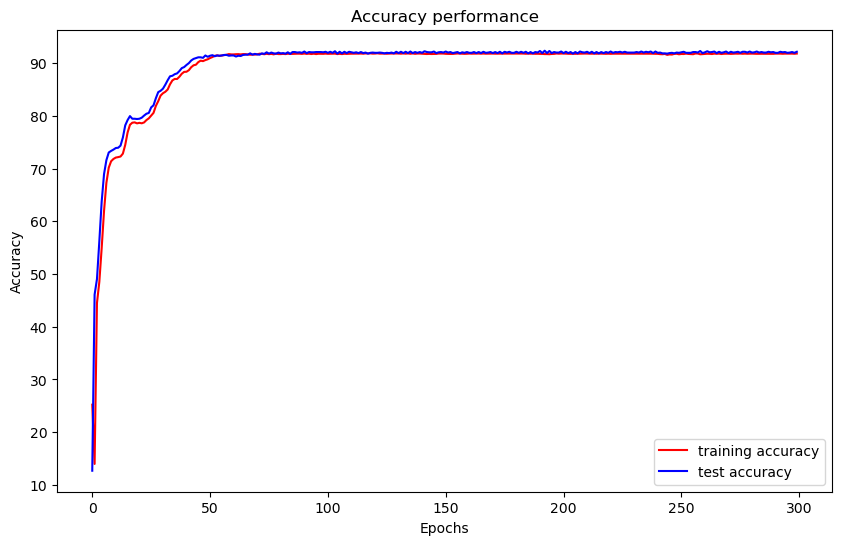

In [12]:
# Do not change this cell
plot_accuracy_performance(train_accuracies, test_accuracies)

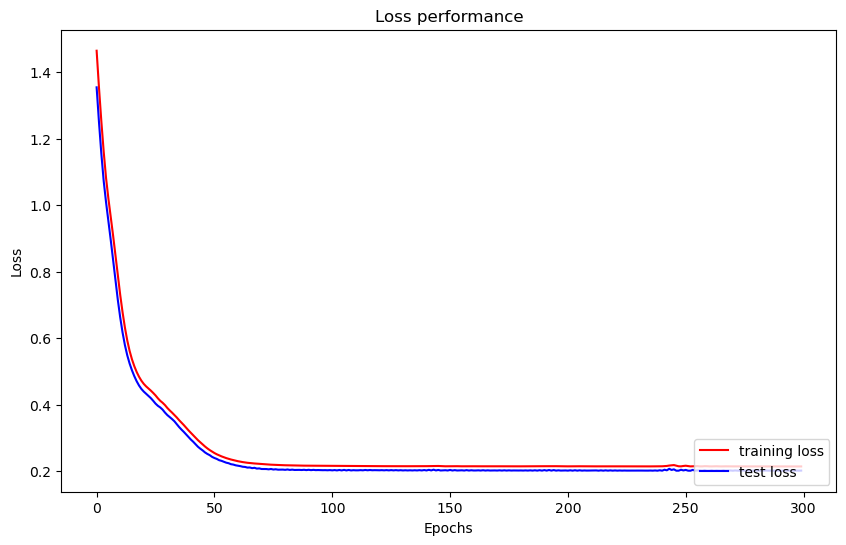

In [13]:
# Do not change this cell
plot_loss_performance(train_losses, test_losses)

/var/folders/pb/hl4zq_3j3zs_rwbm99chwn840000gn/T/ipykernel_48090/4259646906.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
/var/folders/pb/hl4zq_3j3zs_rwbm99chwn840000gn/T/ipykernel_48090/4259646906.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.arange(y_min, y_max, 0.1))


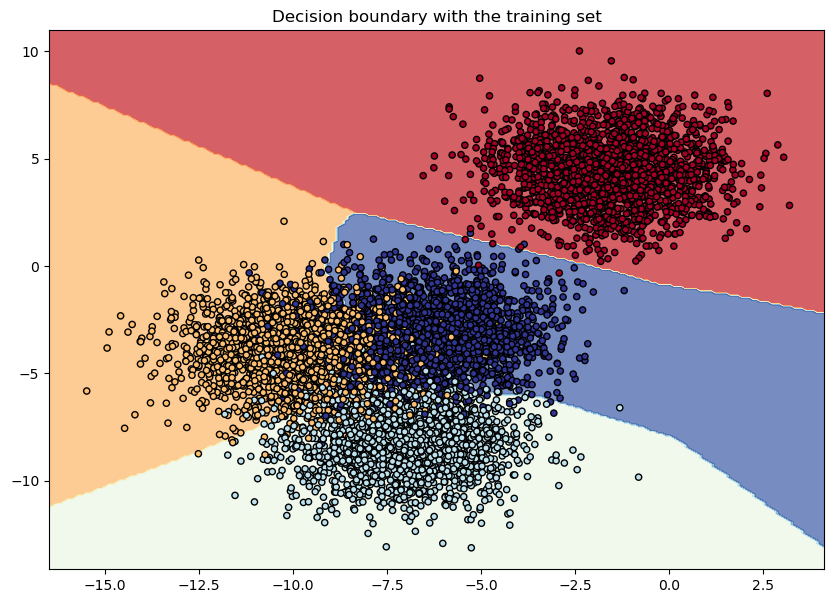

In [14]:
# Do not change this cell
plot_decision_boundary(model, X_train, y_train)